# 1. Описание

## 1.1 Датасет
Для обучения и инференса обоих задач у вас есть следующие поля:
* `title` - заголовок,
* `description` - описание,
* `subcategory` - подкатегория,
* `category` - категория,
* `price` - цена,
* `region` - регион,
* `city` - город,
* `datetime_submitted` - дата размещения.

Таргет первой задачи: `is_bad`. Для второй разметка не предоставляется.

Есть два датасета: `train.csv` и `val.csv`. 
В датасетах могут встречаться (как и, к сожалению, в любых размечаемых данных) некорректные метки.

`train.csv` содержит больше данных, однако разметка в нём менее точная.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

In [2]:
color_bar = ['#00AAFF', '#FF6163','#97CF26','#A169F7','#000000']

In [3]:
dtype_dict = {
    'subcategory': 'category',
    'category': 'category',
    'price': 'float32',
    'region': 'category',
    'city': 'category',
    'is_bad': 'bool'
}

df = pd.read_csv('data/train.csv',
                 dtype=dtype_dict,
                 parse_dates=['datetime_submitted'])

In [4]:
df[:5]

,title,description,subcategory,category,price,region,city,datetime_submitted,is_bad
0,Диван-кровать,Продаем диван-кровать. Удобный механизм - евро...,Мебель и интерьер,Для дома и дачи,7000.0,Россия,Москва,2019-06-01 00:00:15.180656,False
1,Кожух рулевой колонки Даф хф 91 4509834,Кожух рулевой колонки DAF XF 94 (60066004)/\n ...,Запчасти и аксессуары,Транспорт,2290.0,Россия,Москва,2019-06-01 00:00:44.317933,False
2,Дешёвый буст аккаунтов Dota 4,! Буст аккаунтов с ммр выше 1000ммр не беру ! ...,Предложение услуг,Услуги,200.0,Северная Осетия,Владикавказ,2019-06-01 00:00:50.249692,True
3,Телевизор sharp.Смарт тв.Интернет,Продам телевизор . Диагональ 450.наличие входа...,Аудио и видео,Бытовая электроника,25000.0,Калининградская область,Советск,2019-06-01 00:00:50.325799,True
4,Открытка-конверт,Открытки-конверты ручной работы/\nВыполнены в ...,Коллекционирование,Хобби и отдых,150.0,Ставропольский край,Ессентукская,2019-06-01 00:00:56.632655,False


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984487 entries, 0 to 984486
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   title               984487 non-null  object        
 1   description         984487 non-null  object        
 2   subcategory         984487 non-null  category      
 3   category            984487 non-null  category      
 4   price               926439 non-null  float32       
 5   region              984487 non-null  category      
 6   city                984487 non-null  category      
 7   datetime_submitted  984487 non-null  datetime64[ns]
 8   is_bad              984487 non-null  bool          
dtypes: bool(1), category(4), datetime64[ns](1), float32(1), object(2)
memory usage: 32.1+ MB


In [6]:
df.isna().sum()

title                     0
description               0
subcategory               0
category                  0
price                 58048
region                    0
city                      0
datetime_submitted        0
is_bad                    0
dtype: int64

In [7]:
df.describe()

,price
count,9.264390e+05
mean,1.236831e+07
std,2.814821e+09
min,0.000000e+00
25%,9.990000e+02
50%,3.750000e+03
75%,2.000000e+04
max,1.000000e+12


Достаточно большой разброс в признаке `price`, так как в обявлениях присутствуют разные позиции

In [8]:
df.describe(include=['object', 'category'])

,title,description,subcategory,category,region,city
count,984487,984487,984487,984487,984487,984487
unique,642182,984434,50,10,85,3311
top,Платье,Размер 35,Запчасти и аксессуары,Транспорт,Россия,Москва
freq,5188,6,138624,209221,237785,158508


## 1.2 Exploratory Data Analysis

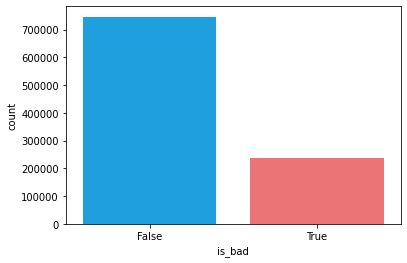

In [9]:
sns.countplot(data=df, x='is_bad', palette=color_bar);

### 1.2.1 Длина текста

Посмотрим на длину текста в разных признаках

In [10]:
def create_series_column(data: pd.DataFrame, column: str) -> pd.Series:
    """Генерация Series из данных по заданной колонке"""
    return pd.Series([len(column) for column in data[column]])

In [11]:
cols_text = ['title', 'description']

for col in cols_text:
    df[f"{col}_lens"] = create_series_column(df, col)

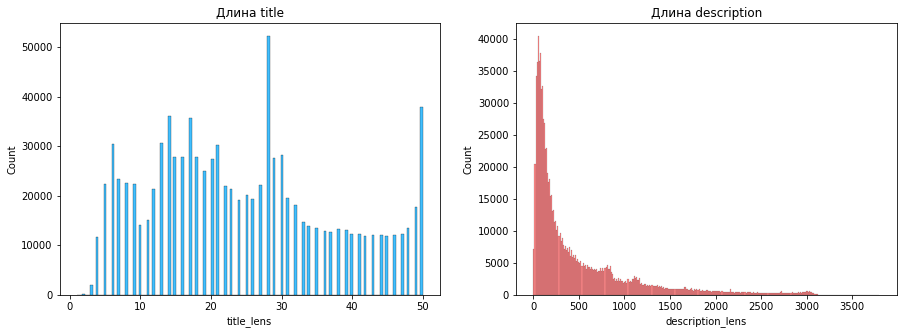

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, col in enumerate(cols_text):
    sns.histplot(df[f"{col}_lens"],
                 ax=axes[i], color=color_bar[i]).set(title=f'Длина {col}')
plt.show()

Посмотрим на длину текстов в новых признаках в разрезе `is_bad`

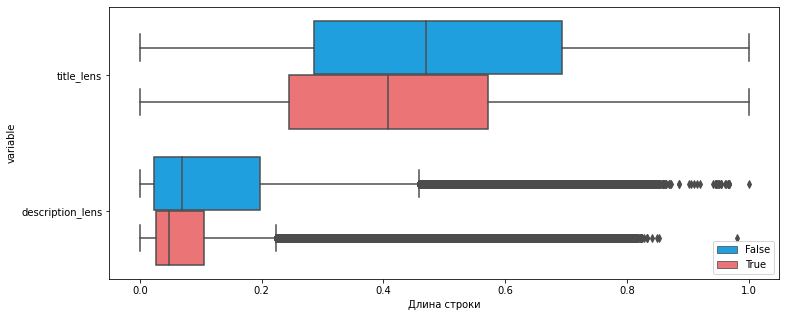

In [13]:
cols_text_melt = ['title_lens', 'description_lens']

scaler = MinMaxScaler()

df_minmax = df[cols_text_melt].copy()
df_minmax[cols_text_melt] = scaler.fit_transform(df[cols_text_melt])
df_melt = pd.concat([df_minmax, df['is_bad']], axis=1)
df_melt = df_melt.melt(id_vars='is_bad', value_vars=cols_text_melt)

plt.figure(figsize=(12, 5))
sns.boxplot(y='variable',
            x='value',
            hue='is_bad',
            data=df_melt,
            palette=color_bar)
plt.legend(loc='lower right')
plt.xlabel("Длина строки")
plt.show()

В среднем видим, что длина текста в обоих признаках при наличие контактов ниже

### 1.2.2 Анализ категорий и подкатегорий

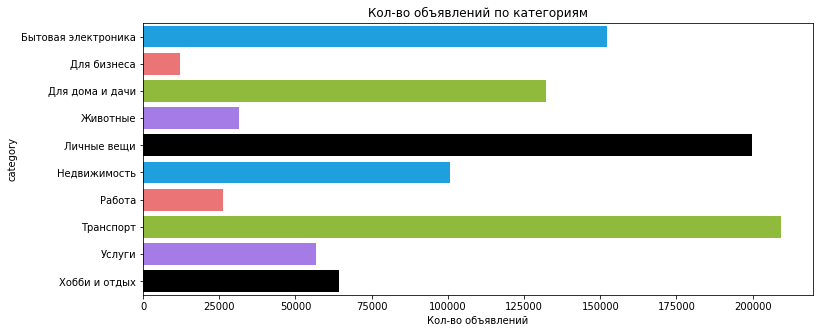

In [14]:
plt.figure(figsize=(12, 5))

sns.countplot(y='category', data=df, palette=color_bar)
plt.title('Кол-во объявлений по категориям')
plt.xlabel("Кол-во объявлений")
plt.show()

Можно отметить, что в части категорий объявлений меньше, возможно, качество по ним будет проседать

In [15]:
def barplot_group(df_data: pd.DataFrame,
                  col_main: str,
                  col_group: str,
                  title: str,
                  orient: str = 'v',
                  palette: list = color_bar,
                  size: tuple = (12, 6)) -> None:
    """
    Построение barplot с нормированными данными с выводом значений на графике
    """

    plt.figure(figsize=size)

    data = (df_data.groupby(
        [col_group])[col_main].value_counts(normalize=True).rename(
            'percentage').mul(100).reset_index().sort_values(col_group))

    data.columns = [col_group, col_main, "percentage"]
    x_orient = col_main
    y_orient = "percentage"

    if orient != 'v':
        x_orient = "percentage"
        y_orient = col_main

    ax = sns.barplot(x=x_orient,
                     y=y_orient,
                     hue=col_group,
                     data=data,
                     palette=palette,
                     orient=orient)

    for ax_ in ax.containers:
        ax.bar_label(ax_, fmt='{:.1f}%')
    plt.title(title, fontsize=16)
    plt.show()

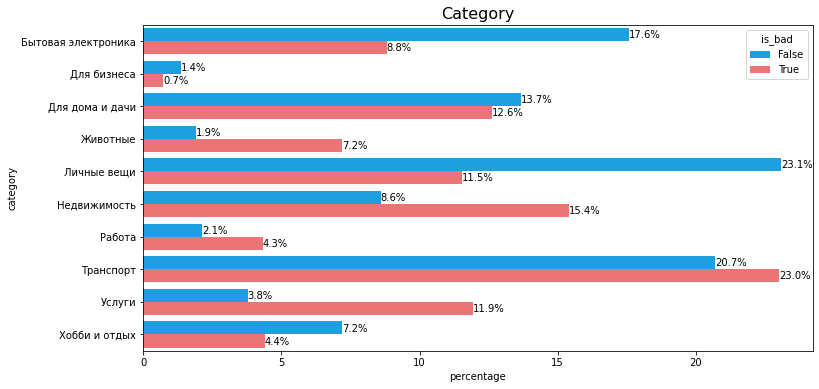

In [16]:
barplot_group(df_data=df,
              col_main='category',
              col_group='is_bad',
              title='Category',
              orient='h')

Заметим, что в некоторых категориях превалирует относительное кол-во контактов в объявлениях 

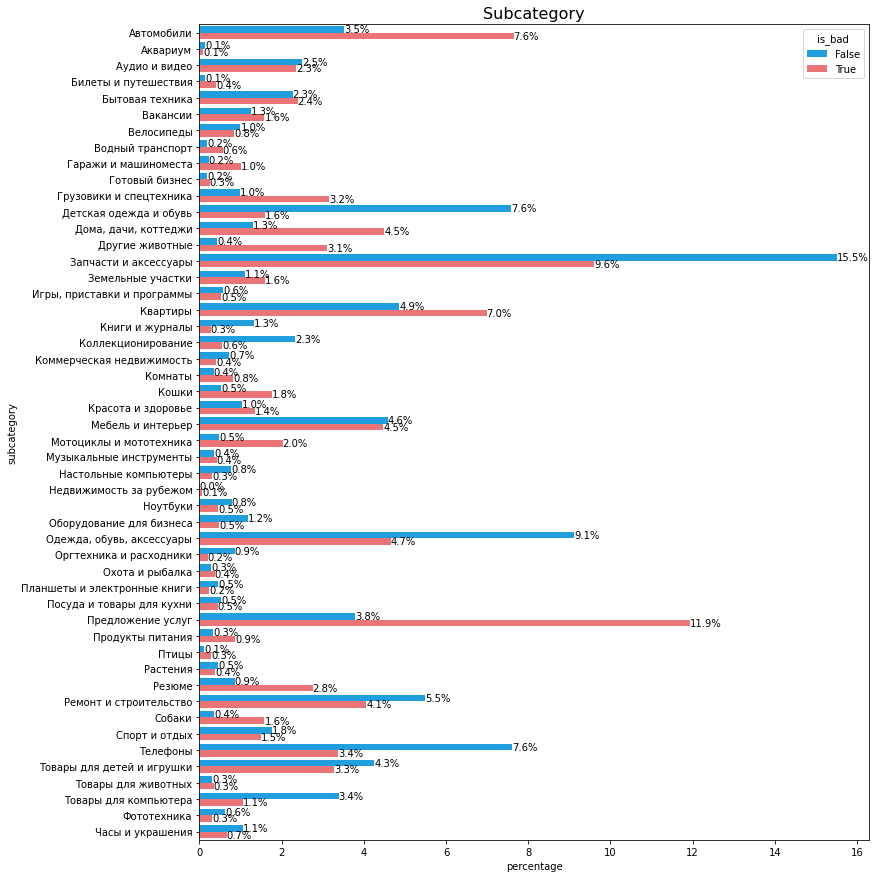

In [17]:
barplot_group(df_data=df,
              col_main='subcategory',
              col_group='is_bad',
              title='Subcategory',
              orient='h',
              size=(12, 15))

In [18]:
df[df.category == 'Недвижимость'][['subcategory']].drop_duplicates()

,subcategory
16,Квартиры
147,Земельные участки
163,Гаражи и машиноместа
171,Коммерческая недвижимость
213,"Дома, дачи, коттеджи"
735,Комнаты
13978,Недвижимость за рубежом


### 1.2.3 Анализ признака времени в разрезе наличия объявлений

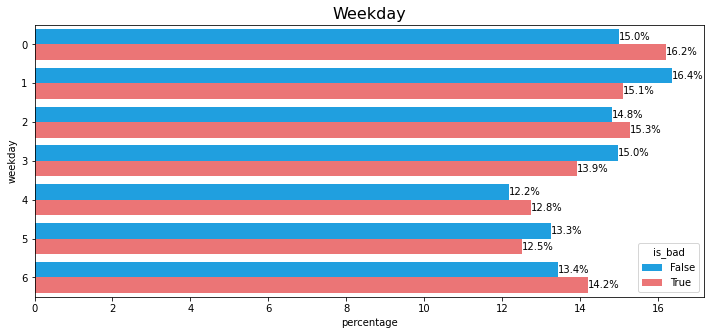

In [19]:
df['weekday'] = df['datetime_submitted'].dt.weekday

barplot_group(df_data=df,
              col_main='weekday',
              col_group='is_bad',
              title='Weekday',
              orient='h',
              size=(12, 5))

Относительно чаще объявления с контактами выкладывают в пн и вс, меньше всего во вт и чт. Возможно, данные закономерности зависят только от даты выгрузки датасета и никак не влияют на наличие контакта в объявлении